In [1]:
%matplotlib inline
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import MACCSkeys
from rdkit.Chem import DataStructs
from rdkit.SimDivFilters.rdSimDivPickers import MaxMinPicker
from itertools import product, compress
from sklearn.svm import SVC
from sklearn.feature_selection import SelectPercentile
from sklearn.feature_selection import chi2
from sklearn.metrics import auc, roc_curve
from sklearn.metrics import confusion_matrix
from tensorboard.plugins.hparams import api as hp
from sklearn.model_selection import train_test_split
%load_ext tensorboard
matplotlib.rcParams.update({'font.size': 24})
plt.style.use("ggplot")

PATH_DATA = "../datasets/SARS2/"
PATH_DATA_GHDDI = "../datasets/SAR1/GHDDI"

In [2]:
def get_features_morgan(input_sdf):
    structures_shared = Chem.SDMolSupplier(input_sdf)
    features = {}
    fps = {}
    mol_names = set()
    error_mols = 0
    for mol in structures_shared:
        if mol is None:
            error_mols += 1
            continue
        if mol.GetProp("_Name") in mol_names:
            continue
        name = int(mol.GetProp("_Name"))
        mol_names.add(name)
        key = Chem.inchi.MolToInchiKey(mol)
        if (name, key) not in features:
            fp = AllChem.GetMorganFingerprintAsBitVect(mol,2,nBits=1024)
            fps[(name, key)] = fp
            arr = np.zeros((0,), dtype=np.int8)
            DataStructs.ConvertToNumpyArray(fp,arr)
            features[(name, key)] = arr
    print(f"Found problems in {error_mols} molecules")
    return fps, features, mol_names

In [3]:
fps_morgan, features_morgan, names_morgan = get_features_morgan(os.path.join(PATH_DATA, "SIM_Broad_MProResults_ligprep.sd"))

RDKit ERROR: [14:42:15] Can't kekulize mol.  Unkekulized atoms: 13 15 16 18 21
RDKit ERROR: 
RDKit ERROR: [14:42:15] ERROR: Could not sanitize molecule ending on line 7247
RDKit ERROR: [14:42:15] ERROR: Can't kekulize mol.  Unkekulized atoms: 13 15 16 18 21
RDKit ERROR: 
RDKit ERROR: [14:42:15] Can't kekulize mol.  Unkekulized atoms: 13 15 16 18 21
RDKit ERROR: 
RDKit ERROR: [14:42:15] ERROR: Could not sanitize molecule ending on line 7448
RDKit ERROR: [14:42:15] ERROR: Can't kekulize mol.  Unkekulized atoms: 13 15 16 18 21
RDKit ERROR: 
RDKit ERROR: [14:42:15] Can't kekulize mol.  Unkekulized atoms: 13 15 16 18 21
RDKit ERROR: 
RDKit ERROR: [14:42:15] ERROR: Could not sanitize molecule ending on line 7649
RDKit ERROR: [14:42:15] ERROR: Can't kekulize mol.  Unkekulized atoms: 13 15 16 18 21
RDKit ERROR: 
RDKit ERROR: [14:42:15] Can't kekulize mol.  Unkekulized atoms: 13 15 16 18 21
RDKit ERROR: 
RDKit ERROR: [14:42:15] ERROR: Could not sanitize molecule ending on line 7848
RDKit ERROR:

Found problems in 24 molecules


In [4]:
threshold_activity = 20 # uM
data_orig_broad = pd.read_csv(os.path.join(PATH_DATA, "20200623_3CLpro_Hits_Broad_DOMPE_Summary-broad.csv"), decimal=",")
data_orig_dompe = pd.read_csv(os.path.join(PATH_DATA, "20200623_3CLpro_Hits_Broad_DOMPE_Summary-dompe.csv"), decimal=",")
data_orig_broad = data_orig_broad.rename(columns={"NAME": "Name",
                                                  "3CL-Pro IC50-15min (µM) (triplicates)": "IC50 µM 15 min",
                                                  "3CLpro\n IC50 slope (µM) (triplicates)": "IC50 µM slope"                                                 })
data_orig_dompe = data_orig_dompe.rename(columns={"IC50 µM\n 15 min\n (red manually confirmed)": "IC50 µM 15 min",
                                                  "IC50 µM\n slope\n (red manually confirmed)": "IC50 µM slope"})
data_full = pd.concat([data_orig_broad, data_orig_dompe])

correspondance_broad = pd.read_csv(os.path.join(PATH_DATA, "DOMPE_Broad_MProResults_IDCorrespondence_broad.csv"), decimal=",")
correspondance_broad = correspondance_broad.rename(columns={"Molecule_id": "Molecule_ID"})
correspondance_dompe = pd.read_csv(os.path.join(PATH_DATA, "DOMPE_Broad_MProResults_IDCorrespondence_dompe.csv"), decimal=",")
correspondance = pd.concat([correspondance_broad, correspondance_dompe])
correspondance = correspondance.rename(columns={"Fraunofer Compound Id": "Compound Id"})
data_full = data_full.merge(correspondance, how="inner", on="Compound Id")

In [5]:
data_full["Is_active"] = (data_full["IC50 µM 15 min"] < threshold_activity).values.astype(int)
print(data_full.shape)

(191, 32)


In [6]:
dup = data_full.duplicated(subset=["Molecule_ID", "Standardized_Molecule_InChIKey"], keep="first")
print(f"Found {sum(dup)} duplicatd entries")
all_dup = data_full.duplicated(subset=["Molecule_ID", "Standardized_Molecule_InChIKey"], keep=False)

Found 10 duplicatd entries


In [7]:
data_full[all_dup]

,Compound Id,Name,DTT sensitivity (if > 30 % loss of activity at 20 µM),Inhibition [%] Primary Screen (single point; 20 µM),"HC\nInhibition [%] (triplicate, 20 µM)","HC\n AV Inhibition [%] (triplicate, 20 µM)\nslope",AV inhibition +DTT 15min \nduplicates,IC50 µM 15 min,IC50 µM slope,%inhibition_d03-KU_LW,...,AV Inhibiton\n 15min,%Inhibition\n_slope PS,%Inhibition\n_15min PS,VeroE6% \nConfluence_d03,VeroE6 % \nInhibition_d03,Chemically reactive?,Molecule_ID,Standardized_Molecule_InChIKey,Standardized_Molecule_Smiles,Is_active
8,SPE_K81330143,Tideglusib,sensitiv,90.94,99.30,99.28,-4.89,0.15,0.14,-3.46,...,NaN,NaN,NaN,NaN,NaN,NaN,3878,PMJIHLSCWIDGMD-UHFFFAOYSA-N,O=C1SN(C(=O)N1Cc2ccccc2)c3cccc4ccccc34,1
9,SPE_K34149328,bonaphthone,sensitiv,95.47,99.37,100.31,37.44,0.16,0.38,-1.01,...,NaN,NaN,NaN,NaN,NaN,NaN,4448,MXWZRRPNVLCHMY-UHFFFAOYSA-N,Brc1ccc2C(=O)C(=O)C=Cc2c1,1
30,SPE_K86972824,OLTIPRAZ,sensitiv,93.83,97.56,101.75,1.56,0.62,1.44,6.11,...,NaN,NaN,NaN,NaN,NaN,NaN,8437,CKNAQFVBEHDJQV-UHFFFAOYSA-N,CC1=C(SSC1=S)c2cnccn2,1
33,SPE_K55591206,(-)-Epigallocatechin Gallate,sensitiv,95.26,98.89,97.04,-22.36,0.72,1.29,-1.41,...,NaN,NaN,NaN,NaN,NaN,NaN,522,WMBWREPUVVBILR-WIYYLYMNSA-N,Oc1cc(O)c2C[C@@H](OC(=O)c3cc(O)c(O)c(O)c3)[C@H...,1
38,SPE_K68408467,PROFLAVINE HEMISULFATE,sensitiv,60.89,76.55,99.87,20.41,0.83,2.02,19.09,...,NaN,NaN,NaN,NaN,NaN,NaN,6835,WDVSHHCDHLJJJR-UHFFFAOYSA-N,Nc1ccc2cc3ccc(N)cc3nc2c1,1
58,SPE_M87138257,Acriflavine hydrochloride,Acriflavine hydrochloride,59.00,67.97,99.10,68.22,1.93,5.10,-26.74,...,NaN,NaN,NaN,NaN,NaN,NaN,6864,NLROCEWTIPMDKX-UHFFFAOYSA-N,C[N]1=C2C=C(N)C=CC2=Cc3ccc(N)cc13,1
74,SPE_K20313525,rosmarinic-acid,sensitiv,95.67,94.92,94.14,-17.76,3.86,4.96,8.26,...,NaN,NaN,NaN,NaN,NaN,NaN,8605,DOUMFZQKYFQNTF-WUTVXBCWSA-N,OC(=O)[C@@H](Cc1ccc(O)c(O)c1)OC(=O)\C=C\c2ccc(...,1
80,SPE_K97874492,ACRIFLAVINIUM HYDROCHLORIDE,sensitiv,75.15,82.15,97.08,-1.10,4.98,9.76,9.74,...,NaN,NaN,NaN,NaN,NaN,NaN,6864,NLROCEWTIPMDKX-UHFFFAOYSA-N,C[N]1=C2C=C(N)C=CC2=Cc3ccc(N)cc13,1
95,SPE_A49172652,LANSOPRAZOLE,sensitiv,97.15,98.57,96.07,-12.10,7.25,10.83,1.65,...,NaN,NaN,NaN,NaN,NaN,NaN,348,MJIHNNLFOKEZEW-UHFFFAOYSA-N,Cc1c(OCC(F)(F)F)ccnc1CS(=O)c2nc3ccccc3[nH]2,1
112,SPE_K76841105,Tazarotene (Avage),Tazarotene (Avage),-880.10,-692.49,108.07,-663.39,13.50,321.75,-2.40,...,NaN,NaN,NaN,NaN,NaN,NaN,445,OGQICQVSFDPSEI-UHFFFAOYSA-N,CCOC(=O)c1ccc(nc1)C#Cc2ccc3SCCC(C)(C)c3c2,1


In [8]:
data_full = data_full[~dup]
print(data_full.shape)

(181, 32)


In [9]:
def get_molecules_from_data(features, fps, data, id_column="Molecule_ID", structure_column="Standardized_Molecule_InChIKey"):
    mol_ids = data[id_column]
    keys = data[structure_column]
    filtered_features = []
    filtered_fps = []
    mask = []
    for id_val in zip(mol_ids, keys):
        mask.append(id_val in features)
        if id_val in features:
            filtered_features.append(features[id_val])
            filtered_fps.append(fps[id_val])
        else:
            print(id_val)
            print([k for k in features if k[0] == id_val[0]])
    return np.array(filtered_features), filtered_fps, mask

In [10]:
features_full, fps_full, mask = get_molecules_from_data(features_morgan, fps_morgan, data_full)

(11947, 'HXQVQGWHFRNKMS-UHFFFAOYSA-M')
[]
(12210, 'XEBWQGVWTUSTLN-UHFFFAOYSA-M')
[]
(5185, 'BPBPYQWMFCTCNG-UHFFFAOYSA-N')
[(5185, 'BPBPYQWMFCTCNG-ZCFIWIBFSA-N'), (5185, 'BPBPYQWMFCTCNG-LURJTMIESA-N')]
(9599, 'BNQDCRGUHNALGH-UHFFFAOYSA-N')
[(9599, 'BNQDCRGUHNALGH-ZCFIWIBFSA-O'), (9599, 'BNQDCRGUHNALGH-ZCFIWIBFSA-N')]
(10107, 'IYUHJBHUQSINCX-XTZHGVARSA-O')
[]
(11027, 'OHCFGBLQZMYRTR-UHFFFAOYSA-M')
[(11027, '')]
(11142, 'GSASOFRDSIKDSN-UHFFFAOYSA-N')
[(11142, 'GSASOFRDSIKDSN-UHFFFAOYSA-L')]
(11287, 'GCHPUOHXXCNSQL-UHFFFAOYSA-N')
[(11287, 'GCHPUOHXXCNSQL-HDICACEKSA-N')]
(8432, 'XKFZYVWWXHCHIX-UHFFFAOYSA-N')
[(8432, 'XKFZYVWWXHCHIX-UHFFFAOYSA-M')]
(617, 'VMWNQDUVQKEIOC-CYBMUJFWSA-N')
[(617, 'VMWNQDUVQKEIOC-CYBMUJFWSA-O')]
(11456, 'JSASWRWALCMOQP-UHFFFAOYSA-N')
[(11456, 'JSASWRWALCMOQP-UHFFFAOYSA-O')]
(882, 'OBMJQRLIQQTJLR-USGQOSEYSA-N')
[(882, 'OBMJQRLIQQTJLR-LJSDLLOGSA-O'), (882, 'OBMJQRLIQQTJLR-USGQOSEYSA-O')]
(332, 'GYQPLLUBTBEWII-UHFFFAOYSA-N')
[(332, 'IXWFLTGIVKLPDY-IBGZPJMESA-N')]
(10

In [11]:
data_filtered = data_full[mask]

Load GHDDI dat set

In [12]:
data_GHDDI_orig = pd.read_csv(os.path.join(PATH_DATA_GHDDI, "3CLProtease_ActiveDataset.csv"), decimal=",")
activity_col = "value_GHDDI"
measures_col = "parameter_GHDDI"
units_col = "unit_GHDDI"
id_col = "Molecule_ID"

In [13]:
data_GHDDI = data_GHDDI_orig.dropna(subset=[activity_col, id_col]).copy()
data_GHDDI[id_col] = data_GHDDI[id_col].astype(int)
data_GHDDI = data_GHDDI[data_GHDDI[measures_col] == "IC50"]
dup = data_GHDDI.duplicated(subset=["Molecule_ID", "Standardized_Molecule_InChIKey"], keep="first")
print(f"Found {sum(dup)} duplicated entries")
data_GHDDI = data_GHDDI[~dup]

Found 0 duplicated entries


In [14]:
def convert_IC50_to_um(data, col_values, col_units):
    new_vals = []
    for val, unit in zip(data[col_values], data[col_units]):
        if unit == "nM":
            new_vals.append(val/1000)
        elif unit == "µM":
            new_vals.append(val)
        else:
            raise ValueError(f"{unit} unit not found!")
    data[col_values] = new_vals
    data[col_units] = "µM"
    return data

In [15]:
data_GHDDI = convert_IC50_to_um(data_GHDDI, activity_col, units_col)
data_GHDDI["Is_active"] = (data_GHDDI[activity_col] < threshold_activity).values.astype(int)

In [16]:
fps_morgan_GHDDI, features_morgan_GHDDI, names_morgan_GHDDI = get_features_morgan(os.path.join(PATH_DATA_GHDDI, "3C-like_protease_GHDDI_ligprep.sdf"))

RDKit WARNING: [14:42:17] Warning: molecule is tagged as 3D, but all Z coords are zero
RDKit ERROR: [14:42:15] ERROR: Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 9 12
RDKit ERROR: 
RDKit ERROR: [14:42:17] Explicit valence for atom # 1 N, 4, is greater than permitted
RDKit ERROR: [14:42:17] ERROR: Could not sanitize molecule ending on line 11557
RDKit WARNING: [14:42:17] Warning: molecule is tagged as 3D, but all Z coords are zero
RDKit ERROR: [14:42:17] ERROR: Explicit valence for atom # 1 N, 4, is greater than permitted
RDKit ERROR: [14:42:18] Explicit valence for atom # 9 C, 5, is greater than permitted
RDKit ERROR: [14:42:18] ERROR: Could not sanitize molecule ending on line 85833
RDKit ERROR: [14:42:18] ERROR: Explicit valence for atom # 9 C, 5, is greater than permitted
RDKit ERROR: [14:42:18] Explicit valence for atom # 9 C, 5, is greater than permitted
RDKit ERROR: [14:42:18] ERROR: Could not sanitize molecule ending on line 86055
RDKit ERROR: [14:42:18] ERROR: Explicit va

Found problems in 8 molecules


RDKit WARNING: [14:42:18] Warning: molecule is tagged as 3D, but all Z coords are zero


In [17]:
features_GHDDI, fps_GHDDI, mask_GHDDI = get_molecules_from_data(features_morgan_GHDDI, fps_morgan_GHDDI, data_GHDDI)

(11459, 'RSUVYMGADVXGOU-BUHFOSPRSA-N')
[(11459, 'RSUVYMGADVXGOU-BUHFOSPRSA-O')]
(13706, 'BSPZFJDYQHDZNR-ASPXRTSYSA-N')
[(13706, 'BSPZFJDYQHDZNR-OGNFBWPZSA-M'), (13706, 'BSPZFJDYQHDZNR-NHAYFPRASA-M'), (13706, 'BSPZFJDYQHDZNR-BOSXTWCSSA-M'), (13706, 'BSPZFJDYQHDZNR-YLAKUSLOSA-M')]
(1630, 'NCHZAFAGBAEJJJ-BAYITLGHSA-N')
[(1630, 'NCHZAFAGBAEJJJ-OGZMYAJTSA-N'), (1630, 'NCHZAFAGBAEJJJ-UHECEFMRSA-N'), (1630, 'NCHZAFAGBAEJJJ-OGZMYAJTSA-M'), (1630, 'NCHZAFAGBAEJJJ-UHECEFMRSA-M')]
(1646, 'FCOYPXSNXIJBGX-ITYLOYPMSA-N')
[(1646, 'FCOYPXSNXIJBGX-ITYLOYPMSA-M')]
(1659, 'FXZXYOPSBKVOFK-UBBRYJJRSA-N')
[(1659, 'YTBDONUJYPKGMO-JXAVFRILSA-N')]
(1660, 'AMCCGTGZJQOWFV-WKDRNLAYSA-N')
[(1660, 'YEJJWGHEFPJNIO-BKZMRJQQSA-N')]
(1661, 'SKLHMRHVVDDIOX-UBBRYJJRSA-N')
[(1661, 'YADCDTJNNBKKMO-JXAVFRILSA-N')]
(1694, 'QFOLMPFZCVBCTJ-UHFFFAOYSA-N')
[(1694, 'QFOLMPFZCVBCTJ-HAVVHWLPSA-O'), (1694, 'QFOLMPFZCVBCTJ-QJOMJCCJSA-O')]
(1695, 'AAVOXWIZJYSGEP-UHFFFAOYSA-N')
[(1695, 'AAVOXWIZJYSGEP-OQKWZONESA-O'), (1695, 'AAVOXWIZJY

In [18]:
data_GHDDI = data_GHDDI[mask_GHDDI]

In [19]:
def filter_duplicates(data, col_id, col_structure):
    dup = data.duplicated(subset=[col_id, col_structure], keep=False)
    to_remove = []
    for id_val in data[dup][col_id].unique():
        dup_data = data[data[col_id] == id_val]
        if len(set(dup_data["Is_active"])) != 1:
            to_remove.append(id_val)
    rm_masks = data[col_id].isin(to_remove)
    data = data[~rm_masks]
    return data, rm_masks

In [20]:
joined_sets = pd.concat([data_filtered, data_GHDDI], ignore_index=True)
joined_features = np.vstack((features_full, features_GHDDI))
joined_fps = fps_full+fps_GHDDI

In [22]:
joined_sets, mask_to_rm = filter_duplicates(joined_sets, id_col, "Standardized_Molecule_InChIKey")
joined_features = joined_features[~mask_to_rm]
joined_fps = list(compress(joined_fps, ~mask_to_rm))

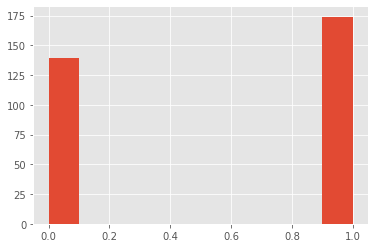

In [27]:
active = joined_sets["Is_active"]
plt.hist(active, bins=10);

In [26]:
def print_metrics(predicted_values, target_values):
    tn, fp, fn, tp = confusion_matrix(target_values, predicted_values >= 0.5).ravel()
    Sn = tp/(tp+fn)
    Sp = tn/(tn+fp)
    precision = tp/(tp+fp)
    ner = (Sn+Sp)/2
    accuracy = (tp+tn)/(tp+tn+fp+fn)
    mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
    print(f"NER: {ner:.3f}, Sensitivity or recall: {Sn:.3f}, Specificity: {Sp:.3f}, Precision: {precision:.3f}, Correctly classified: {accuracy:.3f}, MCC: {mcc:.3f}")
    return [accuracy, mcc]

def plot_confusion(predicted_values, target_values):
    cm = confusion_matrix(target_values, predicted_values >= 0.5)
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax, fmt="g", cmap="Greens")
    # labels, title and ticks
    ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
    ax.set_title('Confusion Matrix'); 
    ax.xaxis.set_ticklabels(['Inactive', 'Active']); ax.yaxis.set_ticklabels(['Inactive', 'Active'])

In [29]:
train_data, test_data, train_labels, test_labels = train_test_split(joined_features, active, test_size=0.25, random_state=42, stratify=active)

In [33]:
accuracy = []
MCCs = []
C_values = np.geomspace(0.01, 1000, num=30)
gamma_values = np.geomspace(0.001, 100, num=30)
for c_val in C_values:
    acc = []
    mcc = []
    for gamma in gamma_values:
        svm = SVC(C=c_val, kernel="rbf", gamma=gamma)
        svm.fit(train_data, train_labels)
        predictions = svm.predict(test_data)
        print(f"C={c_val}, gamma={gamma}")
        vals = print_metrics(predictions, test_labels)
        acc.append(vals[0])
        mcc.append(vals[1])
    accuracy.append(acc)
    MCCs.append(mcc)

C=0.01, gamma=0.001
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.557, Correctly classified: 0.557, MCC: nan
C=0.01, gamma=0.0014873521072935117
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.557, Correctly classified: 0.557, MCC: nan
C=0.01, gamma=0.00221221629107045
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.557, Correctly classified: 0.557, MCC: nan


<ipython-input-26-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-26-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-26-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.01, gamma=0.0032903445623126675
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.557, Correctly classified: 0.557, MCC: nan
C=0.01, gamma=0.004893900918477494
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.557, Correctly classified: 0.557, MCC: nan
C=0.01, gamma=0.007278953843983154
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.557, Correctly classified: 0.557, MCC: nan


<ipython-input-26-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-26-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-26-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.01, gamma=0.010826367338740546
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.557, Correctly classified: 0.557, MCC: nan
C=0.01, gamma=0.01610262027560939
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.557, Correctly classified: 0.557, MCC: nan
C=0.01, gamma=0.02395026619987486
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.557, Correctly classified: 0.557, MCC: nan


<ipython-input-26-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-26-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-26-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.01, gamma=0.03562247890262444
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.557, Correctly classified: 0.557, MCC: nan
C=0.01, gamma=0.0529831690628371
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.557, Correctly classified: 0.557, MCC: nan
C=0.01, gamma=0.07880462815669913
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.557, Correctly classified: 0.557, MCC: nan


<ipython-input-26-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-26-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-26-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.01, gamma=0.11721022975334805
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.557, Correctly classified: 0.557, MCC: nan
C=0.01, gamma=0.1743328822199989
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.557, Correctly classified: 0.557, MCC: nan
C=0.01, gamma=0.2592943797404667
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.557, Correctly classified: 0.557, MCC: nan


<ipython-input-26-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-26-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-26-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.01, gamma=0.38566204211634725
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.557, Correctly classified: 0.557, MCC: nan
C=0.01, gamma=0.5736152510448681
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.557, Correctly classified: 0.557, MCC: nan
C=0.01, gamma=0.8531678524172814
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.557, Correctly classified: 0.557, MCC: nan


<ipython-input-26-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-26-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-26-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.01, gamma=1.2689610031679235
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.557, Correctly classified: 0.557, MCC: nan
C=0.01, gamma=1.8873918221350976
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.557, Correctly classified: 0.557, MCC: nan
C=0.01, gamma=2.8072162039411785
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.557, Correctly classified: 0.557, MCC: nan


<ipython-input-26-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-26-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-26-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.01, gamma=4.175318936560405
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.557, Correctly classified: 0.557, MCC: nan
C=0.01, gamma=6.2101694189156165
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.557, Correctly classified: 0.557, MCC: nan
C=0.01, gamma=9.236708571873866
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.557, Correctly classified: 0.557, MCC: nan


<ipython-input-26-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-26-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-26-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.01, gamma=13.738237958832638
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.557, Correctly classified: 0.557, MCC: nan
C=0.01, gamma=20.43359717856944
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.557, Correctly classified: 0.557, MCC: nan
C=0.01, gamma=30.39195382313201
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.557, Correctly classified: 0.557, MCC: nan


<ipython-input-26-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-26-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-26-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.01, gamma=45.2035365636025
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.557, Correctly classified: 0.557, MCC: nan
C=0.01, gamma=67.23357536499334
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.557, Correctly classified: 0.557, MCC: nan
C=0.01, gamma=100.0
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.557, Correctly classified: 0.557, MCC: nan


<ipython-input-26-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-26-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-26-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.014873521072935119, gamma=0.001
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.557, Correctly classified: 0.557, MCC: nan
C=0.014873521072935119, gamma=0.0014873521072935117
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.557, Correctly classified: 0.557, MCC: nan
C=0.014873521072935119, gamma=0.00221221629107045
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.557, Correctly classified: 0.557, MCC: nan


<ipython-input-26-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-26-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-26-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.014873521072935119, gamma=0.0032903445623126675
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.557, Correctly classified: 0.557, MCC: nan
C=0.014873521072935119, gamma=0.004893900918477494
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.557, Correctly classified: 0.557, MCC: nan
C=0.014873521072935119, gamma=0.007278953843983154
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.557, Correctly classified: 0.557, MCC: nan


<ipython-input-26-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-26-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-26-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.014873521072935119, gamma=0.010826367338740546
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.557, Correctly classified: 0.557, MCC: nan
C=0.014873521072935119, gamma=0.01610262027560939
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.557, Correctly classified: 0.557, MCC: nan
C=0.014873521072935119, gamma=0.02395026619987486
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.557, Correctly classified: 0.557, MCC: nan


<ipython-input-26-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-26-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-26-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.014873521072935119, gamma=0.03562247890262444
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.557, Correctly classified: 0.557, MCC: nan
C=0.014873521072935119, gamma=0.0529831690628371
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.557, Correctly classified: 0.557, MCC: nan
C=0.014873521072935119, gamma=0.07880462815669913
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.557, Correctly classified: 0.557, MCC: nan


<ipython-input-26-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-26-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-26-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.014873521072935119, gamma=0.11721022975334805
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.557, Correctly classified: 0.557, MCC: nan
C=0.014873521072935119, gamma=0.1743328822199989
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.557, Correctly classified: 0.557, MCC: nan
C=0.014873521072935119, gamma=0.2592943797404667
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.557, Correctly classified: 0.557, MCC: nan


<ipython-input-26-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-26-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-26-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.014873521072935119, gamma=0.38566204211634725
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.557, Correctly classified: 0.557, MCC: nan
C=0.014873521072935119, gamma=0.5736152510448681
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.557, Correctly classified: 0.557, MCC: nan
C=0.014873521072935119, gamma=0.8531678524172814
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.557, Correctly classified: 0.557, MCC: nan


<ipython-input-26-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-26-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-26-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.014873521072935119, gamma=1.2689610031679235
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.557, Correctly classified: 0.557, MCC: nan
C=0.014873521072935119, gamma=1.8873918221350976
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.557, Correctly classified: 0.557, MCC: nan
C=0.014873521072935119, gamma=2.8072162039411785
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.557, Correctly classified: 0.557, MCC: nan


<ipython-input-26-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-26-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-26-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.014873521072935119, gamma=4.175318936560405
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.557, Correctly classified: 0.557, MCC: nan
C=0.014873521072935119, gamma=6.2101694189156165
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.557, Correctly classified: 0.557, MCC: nan
C=0.014873521072935119, gamma=9.236708571873866
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.557, Correctly classified: 0.557, MCC: nan


<ipython-input-26-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-26-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-26-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.014873521072935119, gamma=13.738237958832638
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.557, Correctly classified: 0.557, MCC: nan
C=0.014873521072935119, gamma=20.43359717856944
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.557, Correctly classified: 0.557, MCC: nan
C=0.014873521072935119, gamma=30.39195382313201
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.557, Correctly classified: 0.557, MCC: nan


<ipython-input-26-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-26-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-26-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.014873521072935119, gamma=45.2035365636025
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.557, Correctly classified: 0.557, MCC: nan
C=0.014873521072935119, gamma=67.23357536499334
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.557, Correctly classified: 0.557, MCC: nan
C=0.014873521072935119, gamma=100.0
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.557, Correctly classified: 0.557, MCC: nan


<ipython-input-26-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-26-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-26-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.022122162910704492, gamma=0.001
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.557, Correctly classified: 0.557, MCC: nan
C=0.022122162910704492, gamma=0.0014873521072935117
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.557, Correctly classified: 0.557, MCC: nan
C=0.022122162910704492, gamma=0.00221221629107045
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.557, Correctly classified: 0.557, MCC: nan


<ipython-input-26-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-26-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-26-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.022122162910704492, gamma=0.0032903445623126675
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.557, Correctly classified: 0.557, MCC: nan
C=0.022122162910704492, gamma=0.004893900918477494
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.557, Correctly classified: 0.557, MCC: nan
C=0.022122162910704492, gamma=0.007278953843983154
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.557, Correctly classified: 0.557, MCC: nan


<ipython-input-26-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-26-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-26-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.022122162910704492, gamma=0.010826367338740546
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.557, Correctly classified: 0.557, MCC: nan
C=0.022122162910704492, gamma=0.01610262027560939
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.557, Correctly classified: 0.557, MCC: nan
C=0.022122162910704492, gamma=0.02395026619987486
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.557, Correctly classified: 0.557, MCC: nan


<ipython-input-26-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-26-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-26-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.022122162910704492, gamma=0.03562247890262444
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.557, Correctly classified: 0.557, MCC: nan
C=0.022122162910704492, gamma=0.0529831690628371
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.557, Correctly classified: 0.557, MCC: nan
C=0.022122162910704492, gamma=0.07880462815669913
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.557, Correctly classified: 0.557, MCC: nan


<ipython-input-26-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-26-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-26-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.022122162910704492, gamma=0.11721022975334805
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.557, Correctly classified: 0.557, MCC: nan
C=0.022122162910704492, gamma=0.1743328822199989
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.557, Correctly classified: 0.557, MCC: nan
C=0.022122162910704492, gamma=0.2592943797404667
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.557, Correctly classified: 0.557, MCC: nan


<ipython-input-26-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-26-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-26-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.022122162910704492, gamma=0.38566204211634725
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.557, Correctly classified: 0.557, MCC: nan
C=0.022122162910704492, gamma=0.5736152510448681
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.557, Correctly classified: 0.557, MCC: nan
C=0.022122162910704492, gamma=0.8531678524172814
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.557, Correctly classified: 0.557, MCC: nan


<ipython-input-26-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-26-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-26-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.022122162910704492, gamma=1.2689610031679235
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.557, Correctly classified: 0.557, MCC: nan
C=0.022122162910704492, gamma=1.8873918221350976
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.557, Correctly classified: 0.557, MCC: nan
C=0.022122162910704492, gamma=2.8072162039411785
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.557, Correctly classified: 0.557, MCC: nan


<ipython-input-26-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-26-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-26-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.022122162910704492, gamma=4.175318936560405
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.557, Correctly classified: 0.557, MCC: nan
C=0.022122162910704492, gamma=6.2101694189156165
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.557, Correctly classified: 0.557, MCC: nan
C=0.022122162910704492, gamma=9.236708571873866
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.557, Correctly classified: 0.557, MCC: nan


<ipython-input-26-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-26-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-26-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.022122162910704492, gamma=13.738237958832638
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.557, Correctly classified: 0.557, MCC: nan
C=0.022122162910704492, gamma=20.43359717856944
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.557, Correctly classified: 0.557, MCC: nan
C=0.022122162910704492, gamma=30.39195382313201
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.557, Correctly classified: 0.557, MCC: nan


<ipython-input-26-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-26-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-26-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.022122162910704492, gamma=45.2035365636025
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.557, Correctly classified: 0.557, MCC: nan
C=0.022122162910704492, gamma=67.23357536499334
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.557, Correctly classified: 0.557, MCC: nan
C=0.022122162910704492, gamma=100.0
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.557, Correctly classified: 0.557, MCC: nan


<ipython-input-26-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-26-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-26-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.03290344562312668, gamma=0.001
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.557, Correctly classified: 0.557, MCC: nan
C=0.03290344562312668, gamma=0.0014873521072935117
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.557, Correctly classified: 0.557, MCC: nan
C=0.03290344562312668, gamma=0.00221221629107045
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.557, Correctly classified: 0.557, MCC: nan


<ipython-input-26-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-26-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-26-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.03290344562312668, gamma=0.0032903445623126675
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.557, Correctly classified: 0.557, MCC: nan
C=0.03290344562312668, gamma=0.004893900918477494
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.557, Correctly classified: 0.557, MCC: nan
C=0.03290344562312668, gamma=0.007278953843983154
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.557, Correctly classified: 0.557, MCC: nan


<ipython-input-26-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-26-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-26-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.03290344562312668, gamma=0.010826367338740546
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.557, Correctly classified: 0.557, MCC: nan
C=0.03290344562312668, gamma=0.01610262027560939
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.557, Correctly classified: 0.557, MCC: nan
C=0.03290344562312668, gamma=0.02395026619987486
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.557, Correctly classified: 0.557, MCC: nan


<ipython-input-26-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-26-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-26-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.03290344562312668, gamma=0.03562247890262444
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.557, Correctly classified: 0.557, MCC: nan
C=0.03290344562312668, gamma=0.0529831690628371
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.557, Correctly classified: 0.557, MCC: nan
C=0.03290344562312668, gamma=0.07880462815669913
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.557, Correctly classified: 0.557, MCC: nan


<ipython-input-26-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-26-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-26-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.03290344562312668, gamma=0.11721022975334805
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.557, Correctly classified: 0.557, MCC: nan
C=0.03290344562312668, gamma=0.1743328822199989
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.557, Correctly classified: 0.557, MCC: nan
C=0.03290344562312668, gamma=0.2592943797404667
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.557, Correctly classified: 0.557, MCC: nan


<ipython-input-26-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-26-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-26-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.03290344562312668, gamma=0.38566204211634725
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.557, Correctly classified: 0.557, MCC: nan
C=0.03290344562312668, gamma=0.5736152510448681
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.557, Correctly classified: 0.557, MCC: nan
C=0.03290344562312668, gamma=0.8531678524172814
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.557, Correctly classified: 0.557, MCC: nan


<ipython-input-26-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-26-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-26-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.03290344562312668, gamma=1.2689610031679235
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.557, Correctly classified: 0.557, MCC: nan
C=0.03290344562312668, gamma=1.8873918221350976
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.557, Correctly classified: 0.557, MCC: nan
C=0.03290344562312668, gamma=2.8072162039411785
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.557, Correctly classified: 0.557, MCC: nan


<ipython-input-26-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-26-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-26-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.03290344562312668, gamma=4.175318936560405
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.557, Correctly classified: 0.557, MCC: nan
C=0.03290344562312668, gamma=6.2101694189156165
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.557, Correctly classified: 0.557, MCC: nan
C=0.03290344562312668, gamma=9.236708571873866
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.557, Correctly classified: 0.557, MCC: nan


<ipython-input-26-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-26-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-26-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.03290344562312668, gamma=13.738237958832638
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.557, Correctly classified: 0.557, MCC: nan
C=0.03290344562312668, gamma=20.43359717856944
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.557, Correctly classified: 0.557, MCC: nan
C=0.03290344562312668, gamma=30.39195382313201
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.557, Correctly classified: 0.557, MCC: nan


<ipython-input-26-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-26-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-26-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.03290344562312668, gamma=45.2035365636025
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.557, Correctly classified: 0.557, MCC: nan
C=0.03290344562312668, gamma=67.23357536499334
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.557, Correctly classified: 0.557, MCC: nan
C=0.03290344562312668, gamma=100.0
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.557, Correctly classified: 0.557, MCC: nan


<ipython-input-26-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-26-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-26-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.04893900918477494, gamma=0.001
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.557, Correctly classified: 0.557, MCC: nan
C=0.04893900918477494, gamma=0.0014873521072935117
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.557, Correctly classified: 0.557, MCC: nan
C=0.04893900918477494, gamma=0.00221221629107045
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.557, Correctly classified: 0.557, MCC: nan


<ipython-input-26-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-26-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-26-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.04893900918477494, gamma=0.0032903445623126675
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.557, Correctly classified: 0.557, MCC: nan
C=0.04893900918477494, gamma=0.004893900918477494
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.557, Correctly classified: 0.557, MCC: nan
C=0.04893900918477494, gamma=0.007278953843983154
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.557, Correctly classified: 0.557, MCC: nan


<ipython-input-26-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-26-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-26-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.04893900918477494, gamma=0.010826367338740546
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.557, Correctly classified: 0.557, MCC: nan
C=0.04893900918477494, gamma=0.01610262027560939
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.557, Correctly classified: 0.557, MCC: nan
C=0.04893900918477494, gamma=0.02395026619987486
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.557, Correctly classified: 0.557, MCC: nan


<ipython-input-26-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-26-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-26-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.04893900918477494, gamma=0.03562247890262444
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.557, Correctly classified: 0.557, MCC: nan
C=0.04893900918477494, gamma=0.0529831690628371
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.557, Correctly classified: 0.557, MCC: nan
C=0.04893900918477494, gamma=0.07880462815669913
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.557, Correctly classified: 0.557, MCC: nan


<ipython-input-26-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-26-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-26-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.04893900918477494, gamma=0.11721022975334805
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.557, Correctly classified: 0.557, MCC: nan
C=0.04893900918477494, gamma=0.1743328822199989
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.557, Correctly classified: 0.557, MCC: nan
C=0.04893900918477494, gamma=0.2592943797404667
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.557, Correctly classified: 0.557, MCC: nan


<ipython-input-26-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-26-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-26-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.04893900918477494, gamma=0.38566204211634725
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.557, Correctly classified: 0.557, MCC: nan
C=0.04893900918477494, gamma=0.5736152510448681
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.557, Correctly classified: 0.557, MCC: nan
C=0.04893900918477494, gamma=0.8531678524172814
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.557, Correctly classified: 0.557, MCC: nan


<ipython-input-26-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-26-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-26-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.04893900918477494, gamma=1.2689610031679235
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.557, Correctly classified: 0.557, MCC: nan
C=0.04893900918477494, gamma=1.8873918221350976
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.557, Correctly classified: 0.557, MCC: nan
C=0.04893900918477494, gamma=2.8072162039411785
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.557, Correctly classified: 0.557, MCC: nan


<ipython-input-26-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-26-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-26-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.04893900918477494, gamma=4.175318936560405
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.557, Correctly classified: 0.557, MCC: nan
C=0.04893900918477494, gamma=6.2101694189156165
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.557, Correctly classified: 0.557, MCC: nan
C=0.04893900918477494, gamma=9.236708571873866
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.557, Correctly classified: 0.557, MCC: nan


<ipython-input-26-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-26-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-26-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.04893900918477494, gamma=13.738237958832638
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.557, Correctly classified: 0.557, MCC: nan
C=0.04893900918477494, gamma=20.43359717856944
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.557, Correctly classified: 0.557, MCC: nan
C=0.04893900918477494, gamma=30.39195382313201
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.557, Correctly classified: 0.557, MCC: nan


<ipython-input-26-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-26-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-26-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.04893900918477494, gamma=45.2035365636025
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.557, Correctly classified: 0.557, MCC: nan
C=0.04893900918477494, gamma=67.23357536499334
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.557, Correctly classified: 0.557, MCC: nan
C=0.04893900918477494, gamma=100.0
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.557, Correctly classified: 0.557, MCC: nan


<ipython-input-26-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-26-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-26-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.07278953843983153, gamma=0.001
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.557, Correctly classified: 0.557, MCC: nan
C=0.07278953843983153, gamma=0.0014873521072935117
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.557, Correctly classified: 0.557, MCC: nan
C=0.07278953843983153, gamma=0.00221221629107045
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.557, Correctly classified: 0.557, MCC: nan


<ipython-input-26-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-26-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-26-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.07278953843983153, gamma=0.0032903445623126675
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.557, Correctly classified: 0.557, MCC: nan
C=0.07278953843983153, gamma=0.004893900918477494
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.557, Correctly classified: 0.557, MCC: nan
C=0.07278953843983153, gamma=0.007278953843983154
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.557, Correctly classified: 0.557, MCC: nan


<ipython-input-26-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-26-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-26-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.07278953843983153, gamma=0.010826367338740546
NER: 0.514, Sensitivity or recall: 1.000, Specificity: 0.029, Precision: 0.564, Correctly classified: 0.570, MCC: 0.127
C=0.07278953843983153, gamma=0.01610262027560939
NER: 0.600, Sensitivity or recall: 1.000, Specificity: 0.200, Precision: 0.611, Correctly classified: 0.646, MCC: 0.350
C=0.07278953843983153, gamma=0.02395026619987486
NER: 0.600, Sensitivity or recall: 1.000, Specificity: 0.200, Precision: 0.611, Correctly classified: 0.646, MCC: 0.350
C=0.07278953843983153, gamma=0.03562247890262444
NER: 0.571, Sensitivity or recall: 1.000, Specificity: 0.143, Precision: 0.595, Correctly classified: 0.620, MCC: 0.291
C=0.07278953843983153, gamma=0.0529831690628371
NER: 0.514, Sensitivity or recall: 1.000, Specificity: 0.029, Precision: 0.564, Correctly classified: 0.570, MCC: 0.127
C=0.07278953843983153, gamma=0.07880462815669913
NER: 0.514, Sensitivity or recall: 1.000, Specificity: 0.029, Precision: 0.564, Correctly classified: 0.57

<ipython-input-26-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-26-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-26-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.07278953843983153, gamma=0.38566204211634725
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.557, Correctly classified: 0.557, MCC: nan
C=0.07278953843983153, gamma=0.5736152510448681
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.557, Correctly classified: 0.557, MCC: nan
C=0.07278953843983153, gamma=0.8531678524172814
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.557, Correctly classified: 0.557, MCC: nan


<ipython-input-26-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-26-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-26-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.07278953843983153, gamma=1.2689610031679235
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.557, Correctly classified: 0.557, MCC: nan
C=0.07278953843983153, gamma=1.8873918221350976
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.557, Correctly classified: 0.557, MCC: nan
C=0.07278953843983153, gamma=2.8072162039411785
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.557, Correctly classified: 0.557, MCC: nan


<ipython-input-26-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-26-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-26-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.07278953843983153, gamma=4.175318936560405
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.557, Correctly classified: 0.557, MCC: nan
C=0.07278953843983153, gamma=6.2101694189156165
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.557, Correctly classified: 0.557, MCC: nan
C=0.07278953843983153, gamma=9.236708571873866
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.557, Correctly classified: 0.557, MCC: nan


<ipython-input-26-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-26-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-26-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.07278953843983153, gamma=13.738237958832638
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.557, Correctly classified: 0.557, MCC: nan
C=0.07278953843983153, gamma=20.43359717856944
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.557, Correctly classified: 0.557, MCC: nan
C=0.07278953843983153, gamma=30.39195382313201
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.557, Correctly classified: 0.557, MCC: nan


<ipython-input-26-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-26-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-26-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.07278953843983153, gamma=45.2035365636025
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.557, Correctly classified: 0.557, MCC: nan
C=0.07278953843983153, gamma=67.23357536499334
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.557, Correctly classified: 0.557, MCC: nan
C=0.07278953843983153, gamma=100.0
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.557, Correctly classified: 0.557, MCC: nan


<ipython-input-26-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-26-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-26-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.10826367338740546, gamma=0.001
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.557, Correctly classified: 0.557, MCC: nan
C=0.10826367338740546, gamma=0.0014873521072935117
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.557, Correctly classified: 0.557, MCC: nan
C=0.10826367338740546, gamma=0.00221221629107045
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.557, Correctly classified: 0.557, MCC: nan


<ipython-input-26-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-26-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-26-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.10826367338740546, gamma=0.0032903445623126675
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.557, Correctly classified: 0.557, MCC: nan
C=0.10826367338740546, gamma=0.004893900918477494
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.557, Correctly classified: 0.557, MCC: nan
C=0.10826367338740546, gamma=0.007278953843983154
NER: 0.600, Sensitivity or recall: 1.000, Specificity: 0.200, Precision: 0.611, Correctly classified: 0.646, MCC: 0.350


<ipython-input-26-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-26-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.10826367338740546, gamma=0.010826367338740546
NER: 0.600, Sensitivity or recall: 1.000, Specificity: 0.200, Precision: 0.611, Correctly classified: 0.646, MCC: 0.350
C=0.10826367338740546, gamma=0.01610262027560939
NER: 0.600, Sensitivity or recall: 1.000, Specificity: 0.200, Precision: 0.611, Correctly classified: 0.646, MCC: 0.350
C=0.10826367338740546, gamma=0.02395026619987486
NER: 0.600, Sensitivity or recall: 1.000, Specificity: 0.200, Precision: 0.611, Correctly classified: 0.646, MCC: 0.350
C=0.10826367338740546, gamma=0.03562247890262444
NER: 0.600, Sensitivity or recall: 1.000, Specificity: 0.200, Precision: 0.611, Correctly classified: 0.646, MCC: 0.350
C=0.10826367338740546, gamma=0.0529831690628371
NER: 0.600, Sensitivity or recall: 1.000, Specificity: 0.200, Precision: 0.611, Correctly classified: 0.646, MCC: 0.350
C=0.10826367338740546, gamma=0.07880462815669913
NER: 0.529, Sensitivity or recall: 1.000, Specificity: 0.057, Precision: 0.571, Correctly classified: 0.58

<ipython-input-26-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-26-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-26-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.10826367338740546, gamma=0.38566204211634725
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.557, Correctly classified: 0.557, MCC: nan
C=0.10826367338740546, gamma=0.5736152510448681
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.557, Correctly classified: 0.557, MCC: nan
C=0.10826367338740546, gamma=0.8531678524172814
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.557, Correctly classified: 0.557, MCC: nan


<ipython-input-26-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-26-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-26-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.10826367338740546, gamma=1.2689610031679235
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.557, Correctly classified: 0.557, MCC: nan
C=0.10826367338740546, gamma=1.8873918221350976
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.557, Correctly classified: 0.557, MCC: nan
C=0.10826367338740546, gamma=2.8072162039411785
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.557, Correctly classified: 0.557, MCC: nan


<ipython-input-26-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-26-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-26-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.10826367338740546, gamma=4.175318936560405
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.557, Correctly classified: 0.557, MCC: nan
C=0.10826367338740546, gamma=6.2101694189156165
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.557, Correctly classified: 0.557, MCC: nan
C=0.10826367338740546, gamma=9.236708571873866
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.557, Correctly classified: 0.557, MCC: nan


<ipython-input-26-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-26-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-26-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.10826367338740546, gamma=13.738237958832638
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.557, Correctly classified: 0.557, MCC: nan
C=0.10826367338740546, gamma=20.43359717856944
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.557, Correctly classified: 0.557, MCC: nan
C=0.10826367338740546, gamma=30.39195382313201
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.557, Correctly classified: 0.557, MCC: nan


<ipython-input-26-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-26-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-26-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.10826367338740546, gamma=45.2035365636025
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.557, Correctly classified: 0.557, MCC: nan
C=0.10826367338740546, gamma=67.23357536499334
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.557, Correctly classified: 0.557, MCC: nan
C=0.10826367338740546, gamma=100.0
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.557, Correctly classified: 0.557, MCC: nan


<ipython-input-26-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-26-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-26-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.16102620275609392, gamma=0.001
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.557, Correctly classified: 0.557, MCC: nan
C=0.16102620275609392, gamma=0.0014873521072935117
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.557, Correctly classified: 0.557, MCC: nan
C=0.16102620275609392, gamma=0.00221221629107045
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.557, Correctly classified: 0.557, MCC: nan


<ipython-input-26-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-26-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-26-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.16102620275609392, gamma=0.0032903445623126675
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.557, Correctly classified: 0.557, MCC: nan
C=0.16102620275609392, gamma=0.004893900918477494
NER: 0.600, Sensitivity or recall: 1.000, Specificity: 0.200, Precision: 0.611, Correctly classified: 0.646, MCC: 0.350
C=0.16102620275609392, gamma=0.007278953843983154
NER: 0.600, Sensitivity or recall: 1.000, Specificity: 0.200, Precision: 0.611, Correctly classified: 0.646, MCC: 0.350
C=0.16102620275609392, gamma=0.010826367338740546
NER: 0.600, Sensitivity or recall: 1.000, Specificity: 0.200, Precision: 0.611, Correctly classified: 0.646, MCC: 0.350
C=0.16102620275609392, gamma=0.01610262027560939
NER: 0.600, Sensitivity or recall: 1.000, Specificity: 0.200, Precision: 0.611, Correctly classified: 0.646, MCC: 0.350
C=0.16102620275609392, gamma=0.02395026619987486
NER: 0.600, Sensitivity or recall: 1.000, Specificity: 0.200, Precision: 0.611, Correctly classified: 0

<ipython-input-26-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-26-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-26-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.16102620275609392, gamma=0.38566204211634725
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.557, Correctly classified: 0.557, MCC: nan
C=0.16102620275609392, gamma=0.5736152510448681
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.557, Correctly classified: 0.557, MCC: nan
C=0.16102620275609392, gamma=0.8531678524172814
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.557, Correctly classified: 0.557, MCC: nan


<ipython-input-26-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-26-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-26-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.16102620275609392, gamma=1.2689610031679235
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.557, Correctly classified: 0.557, MCC: nan
C=0.16102620275609392, gamma=1.8873918221350976
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.557, Correctly classified: 0.557, MCC: nan
C=0.16102620275609392, gamma=2.8072162039411785
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.557, Correctly classified: 0.557, MCC: nan


<ipython-input-26-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-26-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-26-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.16102620275609392, gamma=4.175318936560405
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.557, Correctly classified: 0.557, MCC: nan
C=0.16102620275609392, gamma=6.2101694189156165
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.557, Correctly classified: 0.557, MCC: nan
C=0.16102620275609392, gamma=9.236708571873866
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.557, Correctly classified: 0.557, MCC: nan


<ipython-input-26-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-26-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-26-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.16102620275609392, gamma=13.738237958832638
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.557, Correctly classified: 0.557, MCC: nan
C=0.16102620275609392, gamma=20.43359717856944
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.557, Correctly classified: 0.557, MCC: nan
C=0.16102620275609392, gamma=30.39195382313201
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.557, Correctly classified: 0.557, MCC: nan


<ipython-input-26-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-26-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-26-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.16102620275609392, gamma=45.2035365636025
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.557, Correctly classified: 0.557, MCC: nan
C=0.16102620275609392, gamma=67.23357536499334
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.557, Correctly classified: 0.557, MCC: nan
C=0.16102620275609392, gamma=100.0
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.557, Correctly classified: 0.557, MCC: nan


<ipython-input-26-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-26-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-26-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.2395026619987486, gamma=0.001
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.557, Correctly classified: 0.557, MCC: nan
C=0.2395026619987486, gamma=0.0014873521072935117
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.557, Correctly classified: 0.557, MCC: nan
C=0.2395026619987486, gamma=0.00221221629107045
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.557, Correctly classified: 0.557, MCC: nan


<ipython-input-26-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.2395026619987486, gamma=0.0032903445623126675
NER: 0.600, Sensitivity or recall: 1.000, Specificity: 0.200, Precision: 0.611, Correctly classified: 0.646, MCC: 0.350
C=0.2395026619987486, gamma=0.004893900918477494
NER: 0.600, Sensitivity or recall: 1.000, Specificity: 0.200, Precision: 0.611, Correctly classified: 0.646, MCC: 0.350
C=0.2395026619987486, gamma=0.007278953843983154
NER: 0.600, Sensitivity or recall: 1.000, Specificity: 0.200, Precision: 0.611, Correctly classified: 0.646, MCC: 0.350
C=0.2395026619987486, gamma=0.010826367338740546
NER: 0.614, Sensitivity or recall: 1.000, Specificity: 0.229, Precision: 0.620, Correctly classified: 0.658, MCC: 0.376
C=0.2395026619987486, gamma=0.01610262027560939
NER: 0.614, Sensitivity or recall: 1.000, Specificity: 0.229, Precision: 0.620, Correctly classified: 0.658, MCC: 0.376
C=0.2395026619987486, gamma=0.02395026619987486
NER: 0.614, Sensitivity or recall: 1.000, Specificity: 0.229, Precision: 0.620, Correctly classified: 0.658

<ipython-input-26-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-26-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-26-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.2395026619987486, gamma=0.38566204211634725
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.557, Correctly classified: 0.557, MCC: nan
C=0.2395026619987486, gamma=0.5736152510448681
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.557, Correctly classified: 0.557, MCC: nan
C=0.2395026619987486, gamma=0.8531678524172814
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.557, Correctly classified: 0.557, MCC: nan


<ipython-input-26-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-26-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-26-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.2395026619987486, gamma=1.2689610031679235
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.557, Correctly classified: 0.557, MCC: nan
C=0.2395026619987486, gamma=1.8873918221350976
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.557, Correctly classified: 0.557, MCC: nan
C=0.2395026619987486, gamma=2.8072162039411785
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.557, Correctly classified: 0.557, MCC: nan


<ipython-input-26-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-26-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-26-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.2395026619987486, gamma=4.175318936560405
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.557, Correctly classified: 0.557, MCC: nan
C=0.2395026619987486, gamma=6.2101694189156165
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.557, Correctly classified: 0.557, MCC: nan
C=0.2395026619987486, gamma=9.236708571873866
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.557, Correctly classified: 0.557, MCC: nan


<ipython-input-26-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-26-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-26-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.2395026619987486, gamma=13.738237958832638
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.557, Correctly classified: 0.557, MCC: nan
C=0.2395026619987486, gamma=20.43359717856944
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.557, Correctly classified: 0.557, MCC: nan
C=0.2395026619987486, gamma=30.39195382313201
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.557, Correctly classified: 0.557, MCC: nan


<ipython-input-26-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-26-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-26-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.2395026619987486, gamma=45.2035365636025
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.557, Correctly classified: 0.557, MCC: nan
C=0.2395026619987486, gamma=67.23357536499334
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.557, Correctly classified: 0.557, MCC: nan
C=0.2395026619987486, gamma=100.0
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.557, Correctly classified: 0.557, MCC: nan


<ipython-input-26-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-26-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.35622478902624444, gamma=0.001
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.557, Correctly classified: 0.557, MCC: nan
C=0.35622478902624444, gamma=0.0014873521072935117
NER: 0.529, Sensitivity or recall: 1.000, Specificity: 0.057, Precision: 0.571, Correctly classified: 0.582, MCC: 0.181
C=0.35622478902624444, gamma=0.00221221629107045
NER: 0.600, Sensitivity or recall: 1.000, Specificity: 0.200, Precision: 0.611, Correctly classified: 0.646, MCC: 0.350
C=0.35622478902624444, gamma=0.0032903445623126675
NER: 0.600, Sensitivity or recall: 1.000, Specificity: 0.200, Precision: 0.611, Correctly classified: 0.646, MCC: 0.350
C=0.35622478902624444, gamma=0.004893900918477494
NER: 0.614, Sensitivity or recall: 1.000, Specificity: 0.229, Precision: 0.620, Correctly classified: 0.658, MCC: 0.376
C=0.35622478902624444, gamma=0.007278953843983154
NER: 0.614, Sensitivity or recall: 1.000, Specificity: 0.229, Precision: 0.620, Correctly classified: 0.658, MCC: 0.

<ipython-input-26-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-26-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-26-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.35622478902624444, gamma=0.5736152510448681
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.557, Correctly classified: 0.557, MCC: nan
C=0.35622478902624444, gamma=0.8531678524172814
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.557, Correctly classified: 0.557, MCC: nan
C=0.35622478902624444, gamma=1.2689610031679235
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.557, Correctly classified: 0.557, MCC: nan


<ipython-input-26-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-26-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-26-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.35622478902624444, gamma=1.8873918221350976
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.557, Correctly classified: 0.557, MCC: nan
C=0.35622478902624444, gamma=2.8072162039411785
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.557, Correctly classified: 0.557, MCC: nan
C=0.35622478902624444, gamma=4.175318936560405
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.557, Correctly classified: 0.557, MCC: nan


<ipython-input-26-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-26-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-26-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.35622478902624444, gamma=6.2101694189156165
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.557, Correctly classified: 0.557, MCC: nan
C=0.35622478902624444, gamma=9.236708571873866
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.557, Correctly classified: 0.557, MCC: nan
C=0.35622478902624444, gamma=13.738237958832638
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.557, Correctly classified: 0.557, MCC: nan


<ipython-input-26-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-26-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-26-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.35622478902624444, gamma=20.43359717856944
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.557, Correctly classified: 0.557, MCC: nan
C=0.35622478902624444, gamma=30.39195382313201
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.557, Correctly classified: 0.557, MCC: nan
C=0.35622478902624444, gamma=45.2035365636025
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.557, Correctly classified: 0.557, MCC: nan


<ipython-input-26-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-26-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-26-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.35622478902624444, gamma=67.23357536499334
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.557, Correctly classified: 0.557, MCC: nan
C=0.35622478902624444, gamma=100.0
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.557, Correctly classified: 0.557, MCC: nan
C=0.529831690628371, gamma=0.001
NER: 0.529, Sensitivity or recall: 1.000, Specificity: 0.057, Precision: 0.571, Correctly classified: 0.582, MCC: 0.181
C=0.529831690628371, gamma=0.0014873521072935117
NER: 0.600, Sensitivity or recall: 1.000, Specificity: 0.200, Precision: 0.611, Correctly classified: 0.646, MCC: 0.350
C=0.529831690628371, gamma=0.00221221629107045
NER: 0.600, Sensitivity or recall: 1.000, Specificity: 0.200, Precision: 0.611, Correctly classified: 0.646, MCC: 0.350
C=0.529831690628371, gamma=0.0032903445623126675
NER: 0.614, Sensitivity or recall: 1.000, Specificity: 0.229, Precision: 0.620, Correctly classified: 0.658, MCC: 0.376
C=0.529831690628371, gam

<ipython-input-26-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-26-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-26-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.529831690628371, gamma=2.8072162039411785
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.557, Correctly classified: 0.557, MCC: nan
C=0.529831690628371, gamma=4.175318936560405
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.557, Correctly classified: 0.557, MCC: nan
C=0.529831690628371, gamma=6.2101694189156165
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.557, Correctly classified: 0.557, MCC: nan


<ipython-input-26-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-26-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-26-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.529831690628371, gamma=9.236708571873866
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.557, Correctly classified: 0.557, MCC: nan
C=0.529831690628371, gamma=13.738237958832638
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.557, Correctly classified: 0.557, MCC: nan
C=0.529831690628371, gamma=20.43359717856944
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.557, Correctly classified: 0.557, MCC: nan


<ipython-input-26-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-26-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-26-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.529831690628371, gamma=30.39195382313201
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.557, Correctly classified: 0.557, MCC: nan
C=0.529831690628371, gamma=45.2035365636025
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.557, Correctly classified: 0.557, MCC: nan
C=0.529831690628371, gamma=67.23357536499334
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.557, Correctly classified: 0.557, MCC: nan


<ipython-input-26-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-26-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
<ipython-input-26-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.529831690628371, gamma=100.0
NER: 0.500, Sensitivity or recall: 1.000, Specificity: 0.000, Precision: 0.557, Correctly classified: 0.557, MCC: nan
C=0.7880462815669912, gamma=0.001
NER: 0.600, Sensitivity or recall: 1.000, Specificity: 0.200, Precision: 0.611, Correctly classified: 0.646, MCC: 0.350
C=0.7880462815669912, gamma=0.0014873521072935117
NER: 0.600, Sensitivity or recall: 1.000, Specificity: 0.200, Precision: 0.611, Correctly classified: 0.646, MCC: 0.350


<ipython-input-26-6e10b4748797>:8: RuntimeWarning: invalid value encountered in true_divide
  mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


C=0.7880462815669912, gamma=0.00221221629107045
NER: 0.614, Sensitivity or recall: 1.000, Specificity: 0.229, Precision: 0.620, Correctly classified: 0.658, MCC: 0.376
C=0.7880462815669912, gamma=0.0032903445623126675
NER: 0.629, Sensitivity or recall: 1.000, Specificity: 0.257, Precision: 0.629, Correctly classified: 0.671, MCC: 0.402
C=0.7880462815669912, gamma=0.004893900918477494
NER: 0.631, Sensitivity or recall: 0.977, Specificity: 0.286, Precision: 0.632, Correctly classified: 0.671, MCC: 0.377
C=0.7880462815669912, gamma=0.007278953843983154
NER: 0.663, Sensitivity or recall: 0.955, Specificity: 0.371, Precision: 0.656, Correctly classified: 0.696, MCC: 0.413
C=0.7880462815669912, gamma=0.010826367338740546
NER: 0.692, Sensitivity or recall: 0.955, Specificity: 0.429, Precision: 0.677, Correctly classified: 0.722, MCC: 0.463
C=0.7880462815669912, gamma=0.01610262027560939
NER: 0.709, Sensitivity or recall: 0.932, Specificity: 0.486, Precision: 0.695, Correctly classified: 0.734

C=1.1721022975334805, gamma=13.738237958832638
NER: 0.543, Sensitivity or recall: 1.000, Specificity: 0.086, Precision: 0.579, Correctly classified: 0.595, MCC: 0.223
C=1.1721022975334805, gamma=20.43359717856944
NER: 0.543, Sensitivity or recall: 1.000, Specificity: 0.086, Precision: 0.579, Correctly classified: 0.595, MCC: 0.223
C=1.1721022975334805, gamma=30.39195382313201
NER: 0.543, Sensitivity or recall: 1.000, Specificity: 0.086, Precision: 0.579, Correctly classified: 0.595, MCC: 0.223
C=1.1721022975334805, gamma=45.2035365636025
NER: 0.543, Sensitivity or recall: 1.000, Specificity: 0.086, Precision: 0.579, Correctly classified: 0.595, MCC: 0.223
C=1.1721022975334805, gamma=67.23357536499334
NER: 0.543, Sensitivity or recall: 1.000, Specificity: 0.086, Precision: 0.579, Correctly classified: 0.595, MCC: 0.223
C=1.1721022975334805, gamma=100.0
NER: 0.543, Sensitivity or recall: 1.000, Specificity: 0.086, Precision: 0.579, Correctly classified: 0.595, MCC: 0.223
C=1.743328822199

C=2.592943797404667, gamma=0.5736152510448681
NER: 0.543, Sensitivity or recall: 1.000, Specificity: 0.086, Precision: 0.579, Correctly classified: 0.595, MCC: 0.223
C=2.592943797404667, gamma=0.8531678524172814
NER: 0.543, Sensitivity or recall: 1.000, Specificity: 0.086, Precision: 0.579, Correctly classified: 0.595, MCC: 0.223
C=2.592943797404667, gamma=1.2689610031679235
NER: 0.543, Sensitivity or recall: 1.000, Specificity: 0.086, Precision: 0.579, Correctly classified: 0.595, MCC: 0.223
C=2.592943797404667, gamma=1.8873918221350976
NER: 0.543, Sensitivity or recall: 1.000, Specificity: 0.086, Precision: 0.579, Correctly classified: 0.595, MCC: 0.223
C=2.592943797404667, gamma=2.8072162039411785
NER: 0.543, Sensitivity or recall: 1.000, Specificity: 0.086, Precision: 0.579, Correctly classified: 0.595, MCC: 0.223
C=2.592943797404667, gamma=4.175318936560405
NER: 0.543, Sensitivity or recall: 1.000, Specificity: 0.086, Precision: 0.579, Correctly classified: 0.595, MCC: 0.223
C=2.5

C=5.736152510448681, gamma=0.01610262027560939
NER: 0.792, Sensitivity or recall: 0.841, Specificity: 0.743, Precision: 0.804, Correctly classified: 0.797, MCC: 0.588
C=5.736152510448681, gamma=0.02395026619987486
NER: 0.781, Sensitivity or recall: 0.818, Specificity: 0.743, Precision: 0.800, Correctly classified: 0.785, MCC: 0.563
C=5.736152510448681, gamma=0.03562247890262444
NER: 0.781, Sensitivity or recall: 0.818, Specificity: 0.743, Precision: 0.800, Correctly classified: 0.785, MCC: 0.563
C=5.736152510448681, gamma=0.0529831690628371
NER: 0.792, Sensitivity or recall: 0.841, Specificity: 0.743, Precision: 0.804, Correctly classified: 0.797, MCC: 0.588
C=5.736152510448681, gamma=0.07880462815669913
NER: 0.769, Sensitivity or recall: 0.909, Specificity: 0.629, Precision: 0.755, Correctly classified: 0.785, MCC: 0.568
C=5.736152510448681, gamma=0.11721022975334805
NER: 0.709, Sensitivity or recall: 0.932, Specificity: 0.486, Precision: 0.695, Correctly classified: 0.734, MCC: 0.477

C=8.531678524172815, gamma=45.2035365636025
NER: 0.543, Sensitivity or recall: 1.000, Specificity: 0.086, Precision: 0.579, Correctly classified: 0.595, MCC: 0.223
C=8.531678524172815, gamma=67.23357536499334
NER: 0.543, Sensitivity or recall: 1.000, Specificity: 0.086, Precision: 0.579, Correctly classified: 0.595, MCC: 0.223
C=8.531678524172815, gamma=100.0
NER: 0.543, Sensitivity or recall: 1.000, Specificity: 0.086, Precision: 0.579, Correctly classified: 0.595, MCC: 0.223
C=12.689610031679234, gamma=0.001
NER: 0.752, Sensitivity or recall: 0.932, Specificity: 0.571, Precision: 0.732, Correctly classified: 0.772, MCC: 0.550
C=12.689610031679234, gamma=0.0014873521072935117
NER: 0.746, Sensitivity or recall: 0.864, Specificity: 0.629, Precision: 0.745, Correctly classified: 0.759, MCC: 0.511
C=12.689610031679234, gamma=0.00221221629107045
NER: 0.803, Sensitivity or recall: 0.864, Specificity: 0.743, Precision: 0.809, Correctly classified: 0.810, MCC: 0.614
C=12.689610031679234, gamm

C=18.873918221350976, gamma=1.8873918221350976
NER: 0.543, Sensitivity or recall: 1.000, Specificity: 0.086, Precision: 0.579, Correctly classified: 0.595, MCC: 0.223
C=18.873918221350976, gamma=2.8072162039411785
NER: 0.543, Sensitivity or recall: 1.000, Specificity: 0.086, Precision: 0.579, Correctly classified: 0.595, MCC: 0.223
C=18.873918221350976, gamma=4.175318936560405
NER: 0.543, Sensitivity or recall: 1.000, Specificity: 0.086, Precision: 0.579, Correctly classified: 0.595, MCC: 0.223
C=18.873918221350976, gamma=6.2101694189156165
NER: 0.543, Sensitivity or recall: 1.000, Specificity: 0.086, Precision: 0.579, Correctly classified: 0.595, MCC: 0.223
C=18.873918221350976, gamma=9.236708571873866
NER: 0.543, Sensitivity or recall: 1.000, Specificity: 0.086, Precision: 0.579, Correctly classified: 0.595, MCC: 0.223
C=18.873918221350976, gamma=13.738237958832638
NER: 0.543, Sensitivity or recall: 1.000, Specificity: 0.086, Precision: 0.579, Correctly classified: 0.595, MCC: 0.223


NER: 0.781, Sensitivity or recall: 0.818, Specificity: 0.743, Precision: 0.800, Correctly classified: 0.785, MCC: 0.563
C=41.753189365604044, gamma=0.03562247890262444
NER: 0.795, Sensitivity or recall: 0.818, Specificity: 0.771, Precision: 0.818, Correctly classified: 0.797, MCC: 0.590
C=41.753189365604044, gamma=0.0529831690628371
NER: 0.781, Sensitivity or recall: 0.818, Specificity: 0.743, Precision: 0.800, Correctly classified: 0.785, MCC: 0.563
C=41.753189365604044, gamma=0.07880462815669913
NER: 0.755, Sensitivity or recall: 0.909, Specificity: 0.600, Precision: 0.741, Correctly classified: 0.772, MCC: 0.544
C=41.753189365604044, gamma=0.11721022975334805
NER: 0.709, Sensitivity or recall: 0.932, Specificity: 0.486, Precision: 0.695, Correctly classified: 0.734, MCC: 0.477
C=41.753189365604044, gamma=0.1743328822199989
NER: 0.663, Sensitivity or recall: 0.955, Specificity: 0.371, Precision: 0.656, Correctly classified: 0.696, MCC: 0.413
C=41.753189365604044, gamma=0.259294379740

C=62.10169418915616, gamma=67.23357536499334
NER: 0.543, Sensitivity or recall: 1.000, Specificity: 0.086, Precision: 0.579, Correctly classified: 0.595, MCC: 0.223
C=62.10169418915616, gamma=100.0
NER: 0.543, Sensitivity or recall: 1.000, Specificity: 0.086, Precision: 0.579, Correctly classified: 0.595, MCC: 0.223
C=92.36708571873865, gamma=0.001
NER: 0.803, Sensitivity or recall: 0.864, Specificity: 0.743, Precision: 0.809, Correctly classified: 0.810, MCC: 0.614
C=92.36708571873865, gamma=0.0014873521072935117
NER: 0.803, Sensitivity or recall: 0.864, Specificity: 0.743, Precision: 0.809, Correctly classified: 0.810, MCC: 0.614
C=92.36708571873865, gamma=0.00221221629107045
NER: 0.789, Sensitivity or recall: 0.864, Specificity: 0.714, Precision: 0.792, Correctly classified: 0.797, MCC: 0.588
C=92.36708571873865, gamma=0.0032903445623126675
NER: 0.815, Sensitivity or recall: 0.886, Specificity: 0.743, Precision: 0.812, Correctly classified: 0.823, MCC: 0.640
C=92.36708571873865, gam

C=137.3823795883264, gamma=2.8072162039411785
NER: 0.543, Sensitivity or recall: 1.000, Specificity: 0.086, Precision: 0.579, Correctly classified: 0.595, MCC: 0.223
C=137.3823795883264, gamma=4.175318936560405
NER: 0.543, Sensitivity or recall: 1.000, Specificity: 0.086, Precision: 0.579, Correctly classified: 0.595, MCC: 0.223
C=137.3823795883264, gamma=6.2101694189156165
NER: 0.543, Sensitivity or recall: 1.000, Specificity: 0.086, Precision: 0.579, Correctly classified: 0.595, MCC: 0.223
C=137.3823795883264, gamma=9.236708571873866
NER: 0.543, Sensitivity or recall: 1.000, Specificity: 0.086, Precision: 0.579, Correctly classified: 0.595, MCC: 0.223
C=137.3823795883264, gamma=13.738237958832638
NER: 0.543, Sensitivity or recall: 1.000, Specificity: 0.086, Precision: 0.579, Correctly classified: 0.595, MCC: 0.223
C=137.3823795883264, gamma=20.43359717856944
NER: 0.543, Sensitivity or recall: 1.000, Specificity: 0.086, Precision: 0.579, Correctly classified: 0.595, MCC: 0.223
C=137.3

C=303.91953823132013, gamma=0.07880462815669913
NER: 0.755, Sensitivity or recall: 0.909, Specificity: 0.600, Precision: 0.741, Correctly classified: 0.772, MCC: 0.544
C=303.91953823132013, gamma=0.11721022975334805
NER: 0.709, Sensitivity or recall: 0.932, Specificity: 0.486, Precision: 0.695, Correctly classified: 0.734, MCC: 0.477
C=303.91953823132013, gamma=0.1743328822199989
NER: 0.663, Sensitivity or recall: 0.955, Specificity: 0.371, Precision: 0.656, Correctly classified: 0.696, MCC: 0.413
C=303.91953823132013, gamma=0.2592943797404667
NER: 0.614, Sensitivity or recall: 1.000, Specificity: 0.229, Precision: 0.620, Correctly classified: 0.658, MCC: 0.376
C=303.91953823132013, gamma=0.38566204211634725
NER: 0.557, Sensitivity or recall: 1.000, Specificity: 0.114, Precision: 0.587, Correctly classified: 0.608, MCC: 0.259
C=303.91953823132013, gamma=0.5736152510448681
NER: 0.543, Sensitivity or recall: 1.000, Specificity: 0.086, Precision: 0.579, Correctly classified: 0.595, MCC: 0

C=672.3357536499335, gamma=0.00221221629107045
NER: 0.775, Sensitivity or recall: 0.864, Specificity: 0.686, Precision: 0.776, Correctly classified: 0.785, MCC: 0.562
C=672.3357536499335, gamma=0.0032903445623126675
NER: 0.775, Sensitivity or recall: 0.864, Specificity: 0.686, Precision: 0.776, Correctly classified: 0.785, MCC: 0.562
C=672.3357536499335, gamma=0.004893900918477494
NER: 0.778, Sensitivity or recall: 0.841, Specificity: 0.714, Precision: 0.787, Correctly classified: 0.785, MCC: 0.562
C=672.3357536499335, gamma=0.007278953843983154
NER: 0.766, Sensitivity or recall: 0.818, Specificity: 0.714, Precision: 0.783, Correctly classified: 0.772, MCC: 0.536
C=672.3357536499335, gamma=0.010826367338740546
NER: 0.769, Sensitivity or recall: 0.795, Specificity: 0.743, Precision: 0.795, Correctly classified: 0.772, MCC: 0.538
C=672.3357536499335, gamma=0.01610262027560939
NER: 0.781, Sensitivity or recall: 0.818, Specificity: 0.743, Precision: 0.800, Correctly classified: 0.785, MCC:

C=1000.0, gamma=20.43359717856944
NER: 0.543, Sensitivity or recall: 1.000, Specificity: 0.086, Precision: 0.579, Correctly classified: 0.595, MCC: 0.223
C=1000.0, gamma=30.39195382313201
NER: 0.543, Sensitivity or recall: 1.000, Specificity: 0.086, Precision: 0.579, Correctly classified: 0.595, MCC: 0.223
C=1000.0, gamma=45.2035365636025
NER: 0.543, Sensitivity or recall: 1.000, Specificity: 0.086, Precision: 0.579, Correctly classified: 0.595, MCC: 0.223
C=1000.0, gamma=67.23357536499334
NER: 0.543, Sensitivity or recall: 1.000, Specificity: 0.086, Precision: 0.579, Correctly classified: 0.595, MCC: 0.223
C=1000.0, gamma=100.0
NER: 0.543, Sensitivity or recall: 1.000, Specificity: 0.086, Precision: 0.579, Correctly classified: 0.595, MCC: 0.223


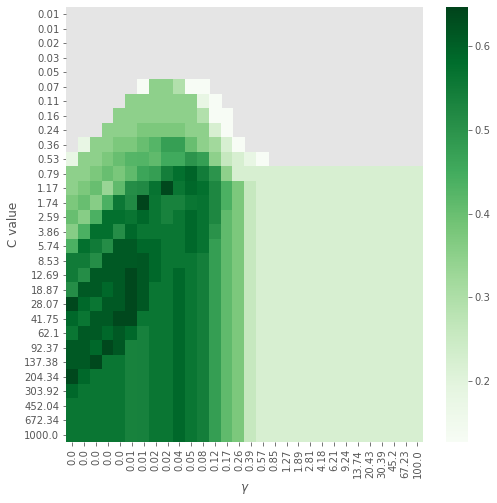

In [34]:
fig, ax = plt.subplots(figsize=(8, 8))
sns.heatmap(MCCs, annot=False, ax = ax, cmap="Greens")
ax.set_yticklabels(np.round(C_values, 2), rotation=0)
ax.set_xticklabels(np.round(gamma_values, 2), rotation=90)
ax.set_ylabel("C value")
ax.set_xlabel(r"$\gamma$")
plt.show()

NER: 0.809, Sensitivity or recall: 0.932, Specificity: 0.686, Precision: 0.788, Correctly classified: 0.823, MCC: 0.647


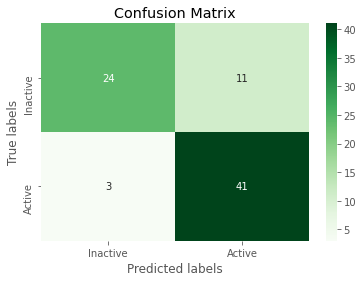

In [38]:
C= 1.743328
gamm = 0.0108
svm = SVC(C=C, kernel="rbf", gamma=gamm)
svm.fit(train_data, train_labels)
predictions = svm.predict(test_data)
vals = print_metrics(predictions, test_labels)
plot_confusion(predictions, test_labels)